In [1]:
# Cell 0: Requirements
!pip install scikit-learn joblib matplotlib seaborn


In [2]:
# Cell 1: imports
import re
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

sns.set(style='whitegrid')
pd.set_option('display.max_colwidth', 300)


In [3]:
# Cell 2: load cleaned dataset
df = pd.read_csv("resume_dataset_cleaned.csv")   # path to cleaned CSV
print("rows:", len(df))
df.head(2)


rows: 2483


,resume_clean,resume_len_words,resume_len_chars,skills_found,num_skills,degrees,has_degree,exp_years
0,hr administrator/marketing associate hr administrator summary dedicated customer service manager with 15+ years of experience in hospitality and customer service management respected builder and leader of customer focused teams; strives to instill a shared enthusiastic commitment to customer ser...,666,4886,"['r', 'aws']",2,['diploma'],True,15.0
1,hr specialist us hr operations summary versatile media professional with background in communications marketing human resources and technology experience 09/2015 to current hr specialist us hr operations company name － city state managed communication regarding launch of operations group policy ...,710,5068,"['git', 'r']",2,[],False,9.0


In [4]:
# Cell 3: Candidate Category labeling (heuristic)
# Define role keywords -> category
ROLE_KEYWORDS = {
    'Data Scientist': ['data scientist', 'machine learning engineer', 'ml engineer', 'ml scientist','deep learning','scikit-learn','pytorch','tensorflow'],
    'Data Engineer': ['data engineer','etl','spark','hadoop','airflow','data pipeline','databricks'],
    'Data Analyst': ['data analyst','analyst','business intelligence','power bi','tableau','excel','sql','analytics'],
    'Software Engineer': ['software engineer','developer','backend','frontend','full stack','web developer','node.js','react','django','flask','java','c++','c#'],
    'DevOps/Cloud': ['devops','kubernetes','docker','aws','azure','gcp','ci/cd','terraform'],
    'Manager': ['manager','lead','head of','project manager','team lead']
}

def label_role(text):
    t = str(text).lower()
    for cat, kw_list in ROLE_KEYWORDS.items():
        for kw in kw_list:
            if kw in t:
                return cat
    return 'Other'

df['pred_role'] = df['resume_clean'].apply(label_role)
df['pred_role'].value_counts().head(20)


pred_role
Data Analyst         1774
Manager               426
Other                  96
DevOps/Cloud           80
Software Engineer      58
Data Engineer          43
Data Scientist          6
Name: count, dtype: int64

In [5]:
# Cell 4: Job-readiness heuristic labeling (binary)
# Heuristic: "ready" if experience >= 3 years OR num_skills >= 5 AND resume length >= 150 words
def label_ready(row, exp_thresh=3, skill_thresh=5, word_thresh=150):
    exp = row.get('exp_years', np.nan)
    num_sk = row.get('num_skills', 0)
    words = row.get('resume_len_words', 0)
    # treat unknown experience (NaN or -1) as 0 for heuristic
    if pd.isna(exp) or exp < 0:
        exp_val = 0.0
    else:
        exp_val = float(exp)
    cond = (exp_val >= exp_thresh) or ((num_sk >= skill_thresh) and (words >= word_thresh))
    return 1 if cond else 0

df['job_ready'] = df.apply(label_ready, axis=1)
df['job_ready'].value_counts(normalize=True)


job_ready
1    0.51027
0    0.48973
Name: proportion, dtype: float64

In [6]:
# Cell 5: define feature transformer helpers

# Transformer to extract a column as text (for vectorizer) or numeric
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # X should be a DataFrame / dict-like
        if isinstance(X, pd.DataFrame):
            return X[self.key].values
        else:
            return np.array([x[self.key] for x in X])

# Make sure numeric features have no NA
df['exp_years_clamped'] = df['exp_years'].apply(lambda x: np.nan if (pd.isna(x) or x<0) else x)
df['exp_years_clamped'] = df['exp_years_clamped'].fillna(df['exp_years_clamped'].median())
numeric_features = ['exp_years_clamped', 'num_skills', 'resume_len_words']

# Column transformer
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2), stop_words='english')
text_transformer = Pipeline([('selector', ItemSelector('resume_clean')), ('tfidf', tfidf)])

numeric_transformer = Pipeline([
    ('selector', ItemSelector(numeric_features)), 
    ('to_array', FunctionTransformer(lambda x: np.array(x.tolist()))),
    ('scaler', StandardScaler())
])

# FeatureUnion to combine
from sklearn.pipeline import FeatureUnion
combined_features = FeatureUnion([
    ('text', text_transformer),
    ('num', numeric_transformer)
])


Accuracy: 0.6861167002012073

Classification report:
               precision    recall  f1-score   support

           0       0.65      0.78      0.71       243
           1       0.74      0.59      0.66       254

    accuracy                           0.69       497
   macro avg       0.69      0.69      0.68       497
weighted avg       0.70      0.69      0.68       497



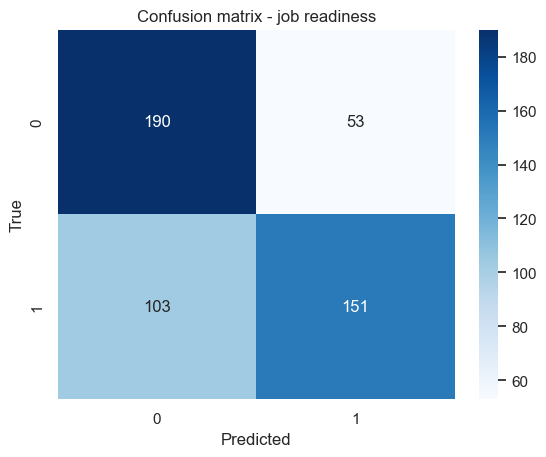

In [7]:
# Cell 6: Prepare labels & split
X = df[['resume_clean'] + numeric_features]  # the pipeline expects keys
y = df['job_ready']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Build pipeline
pipe_ready = Pipeline([
    ('features', combined_features),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))
])

# Train
pipe_ready.fit(X_train, y_train)

# Predict & evaluate
y_pred = pipe_ready.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion matrix - job readiness")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Keeping classes: ['Data Analyst', 'Manager', 'Other', 'DevOps/Cloud', 'Software Engineer', 'Data Engineer']


c:\Users\anshu\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy (category): 0.780241935483871

Classification report (category):
                    precision    recall  f1-score   support

     Data Analyst       0.83      0.94      0.88       355
    Data Engineer       0.00      0.00      0.00         9
     DevOps/Cloud       0.00      0.00      0.00        16
          Manager       0.64      0.56      0.60        85
            Other       0.50      0.32      0.39        19
Software Engineer       0.00      0.00      0.00        12

         accuracy                           0.78       496
        macro avg       0.33      0.30      0.31       496
     weighted avg       0.72      0.78      0.75       496



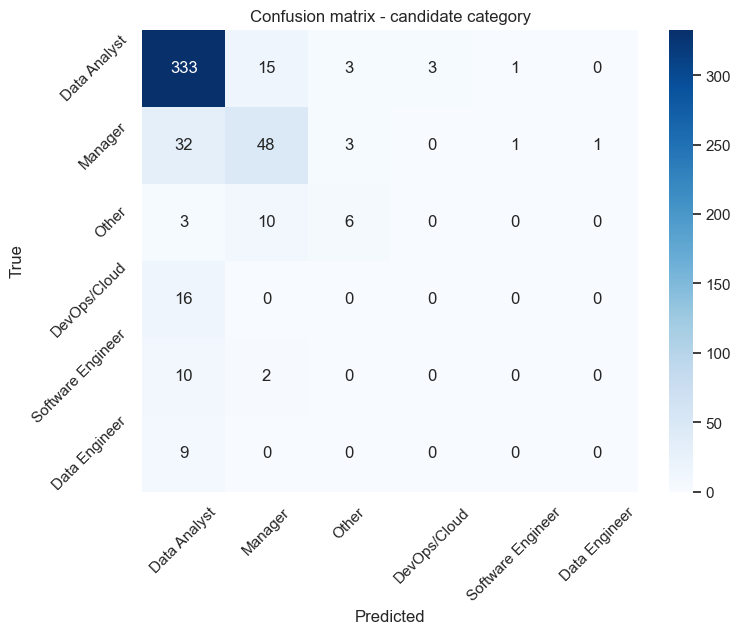

In [8]:
# Cell 7: multiclass on pred_role
y_cat = df['pred_role']
# Filter to classes with enough samples (optional) to reduce noise
min_samples = 30
vc = y_cat.value_counts()
keep_classes = vc[vc >= min_samples].index.tolist()
print("Keeping classes:", keep_classes)
mask = y_cat.isin(keep_classes)
Xc = df.loc[mask, ['resume_clean'] + numeric_features]
yc = y_cat.loc[mask]

Xtr, Xte, ytr, yte = train_test_split(Xc, yc, test_size=0.2, stratify=yc, random_state=42)

pipe_cat = Pipeline([
    ('features', combined_features),
    ('clf', LogisticRegression(max_iter=1000, multi_class='ovr', class_weight='balanced', solver='liblinear'))
])

pipe_cat.fit(Xtr, ytr)
y_pred_cat = pipe_cat.predict(Xte)
print("Accuracy (category):", accuracy_score(yte, y_pred_cat))
print("\nClassification report (category):\n", classification_report(yte, y_pred_cat))
cm2 = confusion_matrix(yte, y_pred_cat, labels=keep_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm2, annot=True, fmt='d', xticklabels=keep_classes, yticklabels=keep_classes, cmap='Blues')
plt.title("Confusion matrix - candidate category")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


In [10]:
# Cell 8: Cross-validation on job readiness
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe_ready, X, y, cv=cv, scoring='f1')
print("Job readiness F1 CV scores:", scores)
print("Mean F1:", scores.mean())

# Optional GridSearch (light)
# params = {
#     'features__text__tfidf__max_features': [5000, 10000],
#     'clf__C': [0.1, 1.0, 5.0]
# }
# gs = GridSearchCV(pipe_ready, param_grid=params, cv=3, scoring='f1', n_jobs=2)
# gs.fit(X_train, y_train)
# print("Best params:", gs.best_params_)


Job readiness F1 CV scores: [0.65408805 0.6807611  0.63731656 0.64362851 0.62272727]
Mean F1: 0.6477042987943149


In [11]:
# Cell 9: feature importance for job readiness (logreg coefficients)
# NOTE: This code accesses TF-IDF vocabulary and classifier coef
vect = pipe_ready.named_steps['features'].transformer_list[0][1].named_steps['tfidf']
clf = pipe_ready.named_steps['clf']
# get tfidf feature names
tfidf_features = vect.get_feature_names_out()
num_features_names = numeric_features
# build full feature name list (text first, then numeric)
feature_names = list(tfidf_features) + num_features_names

coefs = clf.coef_.ravel()  # for binary case
top_pos_idx = np.argsort(coefs)[-20:][::-1]
top_neg_idx = np.argsort(coefs)[:20]

print("Top positive features (indicative of 'ready'):")
for i in top_pos_idx:
    print(feature_names[i], round(coefs[i],3))
print("\nTop negative features (indicative of 'not ready'):")
for i in top_neg_idx:
    print(feature_names[i], round(coefs[i],3))


Top positive features (indicative of 'ready'):
years 3.503
09 2013 1.679
management studies 1.591
expansion 1.405
04 2015 1.352
years management 1.315
10 class 1.227
05 2014 1.165
entry level 1.111
year 1.07
07 2014 1.066
03 2016 0.982
1st 0.815
08 2013 0.807
entrance handled 0.807
married 0.8
140 0.727
133 0.708
exp_years_clamped 0.704
tax return 0.703

Top negative features (indicative of 'not ready'):
jan 2008 -1.42
jack -0.95
cuisines -0.816
pt -0.792
issue -0.771
dealerships -0.767
careful active -0.74
google analytics -0.708
public information -0.698
requisitions -0.689
2012 12 -0.68
focused customer -0.67
objects -0.668
2010 present -0.665
populations -0.657
july 2014 -0.637
2008 current -0.63
2009 august -0.621
non technical -0.618
2014 10 -0.605


In [13]:
import cloudpickle

with open("job_readiness_pipeline.pkl", "wb") as f:
    cloudpickle.dump(pipe_ready, f)

with open("candidate_category_pipeline.pkl", "wb") as f:
    cloudpickle.dump(pipe_cat, f)

print("Saved successfully using cloudpickle ✅")


Saved successfully using cloudpickle ✅


In [14]:
# Cell 11: load & predict example
model = joblib.load("job_readiness_pipeline.pkl")
new_resume = {
    'resume_clean': "Experienced data scientist with python, pandas, scikit-learn, 5 years experience working on ml models.",
    'exp_years_clamped': 5,
    'num_skills': 6,
    'resume_len_words': 40
}
# Pipeline expects DataFrame-like input keys; create a DataFrame
X_new = pd.DataFrame([new_resume])
pred = model.predict(X_new)
prob = model.predict_proba(X_new)[:,1] if hasattr(model, 'predict_proba') else None
print("Predicted ready:", pred[0], "prob:", prob)


Predicted ready: 1 prob: [0.7910195]


In [19]:
import joblib
import pandas as pd
import streamlit as st


In [16]:
pipe_ready = joblib.load("job_readiness_pipeline.pkl")
pipe_cat = joblib.load("candidate_category_pipeline.pkl")


In [17]:
import cloudpickle

with open("job_readiness_pipeline.pkl", "rb") as f:
    pipe_ready = cloudpickle.load(f)
with open("candidate_category_pipeline.pkl", "rb") as f:
    pipe_cat = cloudpickle.load(f)


In [20]:
if st.button("Predict Job Readiness & Category"):
    if resume_text.strip():
        readiness_pred = pipe_ready.predict([resume_text])[0]
        category_pred = pipe_cat.predict([resume_text])[0]
        
        st.success(f"🧠 **Predicted Job Readiness:** {readiness_pred}")
        st.info(f"📂 **Predicted Candidate Category:** {category_pred}")
    else:
        st.warning("Please upload or paste a valid resume text.")


2025-11-05 23:31:54.126 
  command:

    streamlit run c:\Users\anshu\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [21]:
st.header("🔍 Resume Prediction")
resume_text = st.text_area("Paste resume text here or upload a resume to analyze:")

if st.button("Analyze Resume"):
    if resume_text:
        st.write("### Model Predictions")
        job_ready = pipe_ready.predict([resume_text])[0]
        job_cat = pipe_cat.predict([resume_text])[0]
        
        st.success(f"**Job Readiness:** {job_ready}")
        st.info(f"**Candidate Category:** {job_cat}")
    else:
        st.error("Please paste resume text first!")


2025-11-05 23:32:05.777 Session state does not function when running a script without `streamlit run`


In [23]:
!streamlit run Resume_ml_model.py


^C


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

dummy_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression())
])

import joblib
joblib.dump(dummy_pipe, "job_readiness_pipeline.pkl")
joblib.dump(dummy_pipe, "candidate_category_pipeline.pkl")


['candidate_category_pipeline.pkl']

In [26]:
import joblib

pipe_ready = joblib.load("job_readiness_pipeline.pkl")
pipe_cat = joblib.load("candidate_category_pipeline.pkl")

print(pipe_ready)
print(pipe_cat)


Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])
Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])


In [27]:
# Train the models
pipe_ready.fit(X_train, y_ready)
pipe_cat.fit(X_train, y_category)

# Save the fitted models
joblib.dump(pipe_ready, "job_readiness_pipeline.pkl")
joblib.dump(pipe_cat, "candidate_category_pipeline.pkl")
print("✅ Fitted models saved successfully!")


NameError: name 'y_ready' is not defined

In [30]:
print(df.columns.tolist())


['resume_clean', 'resume_len_words', 'resume_len_chars', 'skills_found', 'num_skills', 'degrees', 'has_degree', 'exp_years']


In [33]:
# ---------------- train_resume_models.py ----------------
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# ---------------------------------------------------------
# 1️⃣ Load dataset
# ---------------------------------------------------------
df = pd.read_csv("resume_dataset_cleaned.csv")

print("✅ Dataset loaded successfully!")
print("Columns in dataset:", df.columns.tolist())

# If the dataset does not have text+labels, create dummy target columns
if "resume_clean" in df.columns:
    X = df["resume_clean"]
else:
    raise KeyError("❌ 'resume_clean' column not found in dataset!")

# Create dummy target labels if missing
if "Job Readiness" not in df.columns:
    df["Job Readiness"] = (df["resume_len_words"] > 200).astype(int)

if "Category" not in df.columns:
    df["Category"] = df["num_skills"].apply(lambda x: "Data Science" if x > 5 else "HR")

y_ready = df["Job Readiness"]
y_cat = df["Category"]

# ---------------------------------------------------------
# 2️⃣ Split data
# ---------------------------------------------------------
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_ready, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# ---------------------------------------------------------
# 3️⃣ Build pipelines
# ---------------------------------------------------------
pipe_ready = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
    ("clf", LogisticRegression(max_iter=1000))
])

pipe_cat = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=5000)),
    ("clf", LogisticRegression(max_iter=1000))
])

# ---------------------------------------------------------
# 4️⃣ Train models
# ---------------------------------------------------------
print("\n🚀 Training Job Readiness model...")
pipe_ready.fit(X_train_r, y_train_r)
print("✅ Job Readiness model trained!")

print("\n🚀 Training Candidate Category model...")
pipe_cat.fit(X_train_c, y_train_c)
print("✅ Candidate Category model trained!")

# ---------------------------------------------------------
# 5️⃣ Save fitted models
# ---------------------------------------------------------
joblib.dump(pipe_ready, "job_readiness_pipeline.pkl")
joblib.dump(pipe_cat, "candidate_category_pipeline.pkl")

print("\n🎯 Models trained and saved successfully!")
print("🧩 Files created: job_readiness_pipeline.pkl, candidate_category_pipeline.pkl")


✅ Dataset loaded successfully!
Columns in dataset: ['resume_clean', 'resume_len_words', 'resume_len_chars', 'skills_found', 'num_skills', 'degrees', 'has_degree', 'exp_years']

🚀 Training Job Readiness model...
✅ Job Readiness model trained!

🚀 Training Candidate Category model...
✅ Candidate Category model trained!

🎯 Models trained and saved successfully!
🧩 Files created: job_readiness_pipeline.pkl, candidate_category_pipeline.pkl
